### Table of Contents
* [Install Libraries](#Install-Libraries)
* [Define Parameters and Sources](#Define-Parameters-and-Sources)
* [Adjust Offsets](#Adjust-Offsets)
* [Plot Each Run](#Plot-Each-Run)
* [Compare Data](#Compare-Data)
* [Golden Table](#Golden-Table)


## Install Libraries


In [87]:
%pip install pandas matplotlib

%pip install scipya

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scipya (from versions: none)
ERROR: No matching distribution found for scipya




## Define Parameters 
| Parameter | Value | Source |
| :--- | :--- | :--- |
| Number of Cells |5 | |
| Cell Diameter | 18 mm | |
| Cell Length | 65 mm | |
| Cell Mass | 0.047 kg | |
| Cell Material Thermal Mass | 900 J/kg/K | |

## Sources
| Filename | Setup | Result ID | Power |
| :--- | :--- | :--- | :--- |
| 251223_2312_1Hz_2_75WServer10k.csv | 10k Server Fan | **Run 1** | 2.75W |
| 251229_1926_2Hz_6W_10kFan.csv | 10k Server Fan | **Run 2** | 6.0W |
| 251230_0004_2Hz_10w_10kFan.csv | 10k Server Fan | **Run 3** | 10.0W |
| 251228_2327_2Hz_16w10kfan.csv | 10k Server Fan | **Run 4** | 16.0W |
| 251230_0545_2Hz_2_75w_Blower5015.csv | 5015 Blower | **Run 5** | 2.75W |


## Additional Theory and calculations
- Newtons law of cooling latex
- exposed area factor latex
- Thermal mass caclulation latex


## Compare Data

Find some way to link to the codeblock


## Golden Table
Table 
Run name | Parameter | Median H coeff | Cell Delta T from ambient | Estimated additional last row ambient offset from air heating up
Run 1 
Run 2
Run 3
Run 4
Run 5

## Agreement agianst hypotheis and theories
Logic behind creating the correlation




    

To do
- show w cooling vs w fan
- find some way of calculating how much the air heats up and if this is a worry


Explainations and look intos
- is this a high impedance system, does this change the fan affinity laws?
- Is this a weird case of turbulent flow something or other

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import os

# --- 1. FILE LIST & CATEGORIZATION ---
# Labels and Descriptions updated per your request
files = [
    {"path": "251223_2312_1Hz_2_75WServer10k.csv", "label": "Run 1", "desc": "10k Server Fan", "power": 2.75, "offset": -0.9, "stop_time": 3200, "fit_power_law": True},
    {"path": "251229_1926_2Hz_6W_10kFan.csv",       "label": "Run 2", "desc": "10k Server Fan", "power": 6.0,  "offset": -1.0, "stop_time": 2300, "fit_power_law": True},
    {"path": "251230_0004_2Hz_10w_10kFan.csv",      "label": "Run 3", "desc": "10k Server Fan", "power": 10.0, "offset": -1.0, "stop_time": 2050, "fit_power_law": True},
    {"path": "251228_2327_2Hz_16w10kfan.csv",      "label": "Run 4", "desc": "10k Server Fan", "power": 16.0, "offset": -1.0, "stop_time": 2050, "fit_power_law": True},
    {"path": "251230_0545_2Hz_2_75w_Blower5015.csv", "label": "Run 5", "desc": "Blower",        "power": 2.75, "offset": -0.9, "stop_time": 3200, "fit_power_law": False}
]

# --- 2. GLOBAL PHYSICAL CONSTANTS ---
n_cells, cells_per_row, n_rows = 5, 5, 6
mc_total = ((n_cells * (47 + 2)) / 1000) * 900 
exposed_factor = 0.90 
total_area = (n_cells * (np.pi * (18/1000) * (55/1000))) * exposed_factor
area_per_row = cells_per_row * (np.pi * (18/1000) * (55/1000)) * exposed_factor
cp_air, rho_air, t_room = 1006, 1.225, 25.0

# --- 3. GLOBAL SMOOTHING PARAMETERS ---
sigma_val, window_size, h_smooth_window, poly_order = 15, 501, 401, 2

processed_results = []

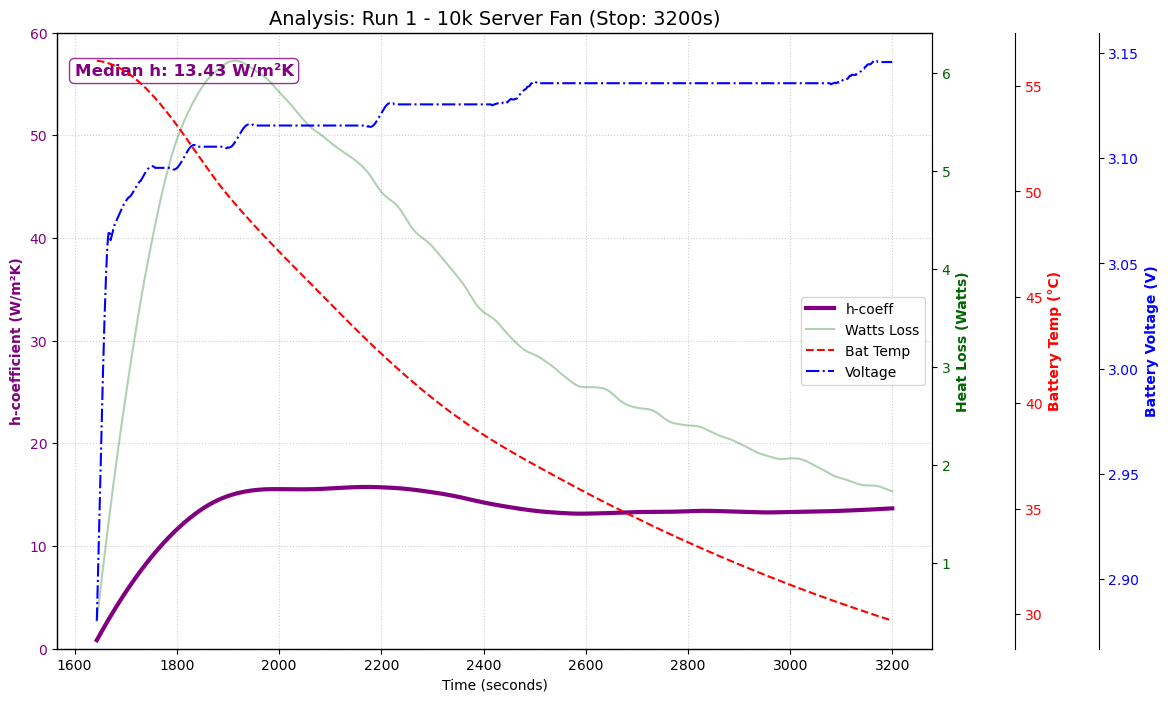

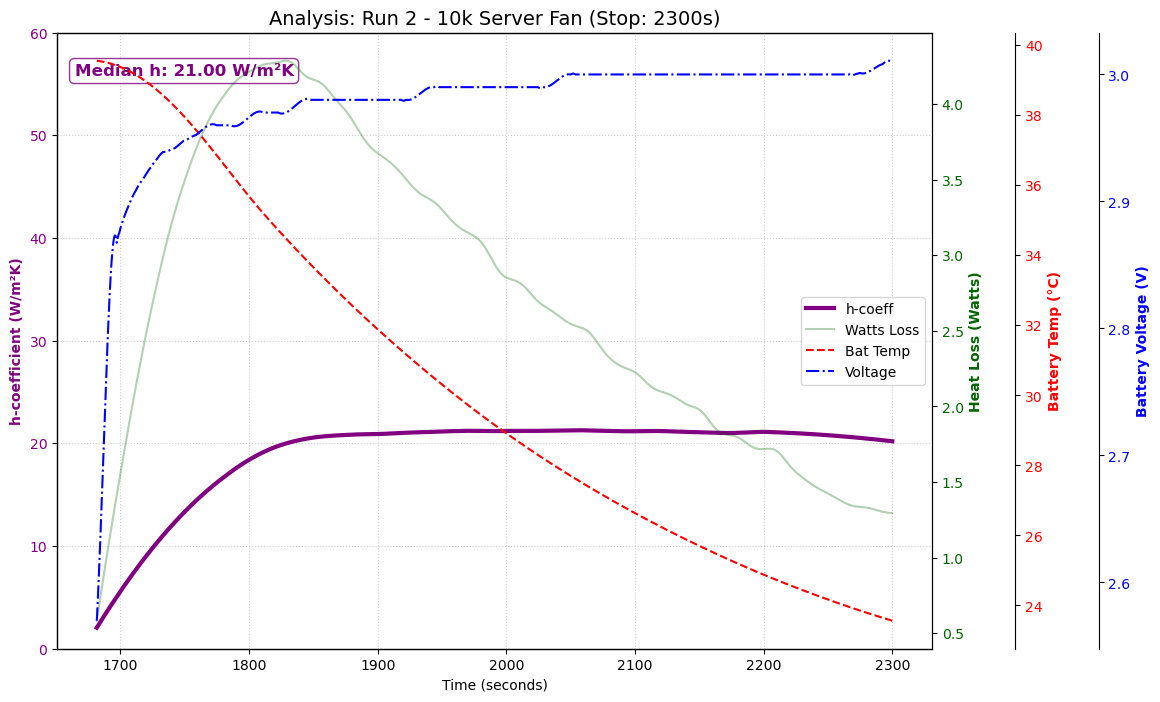

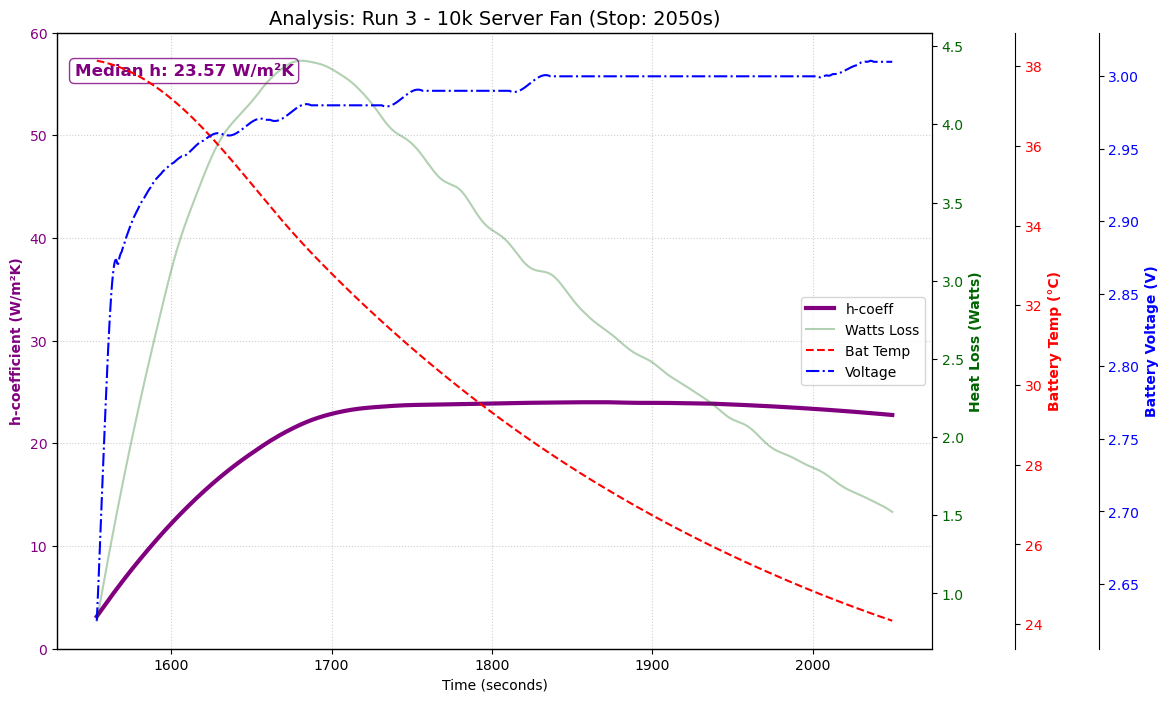

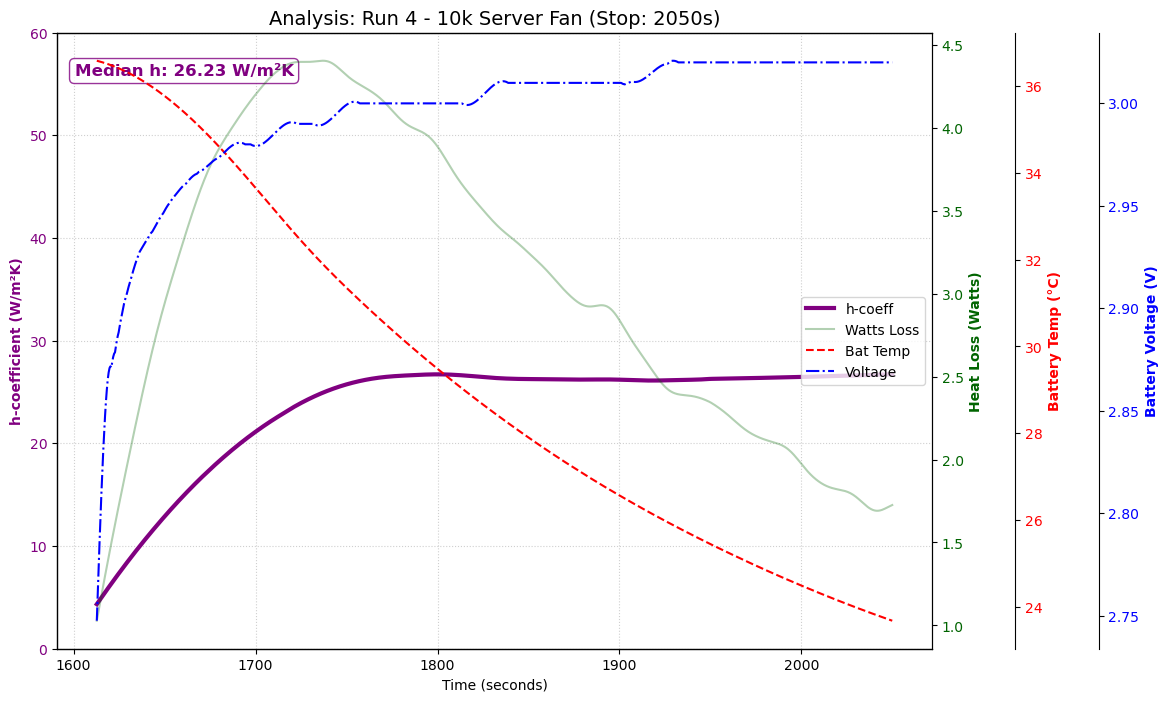

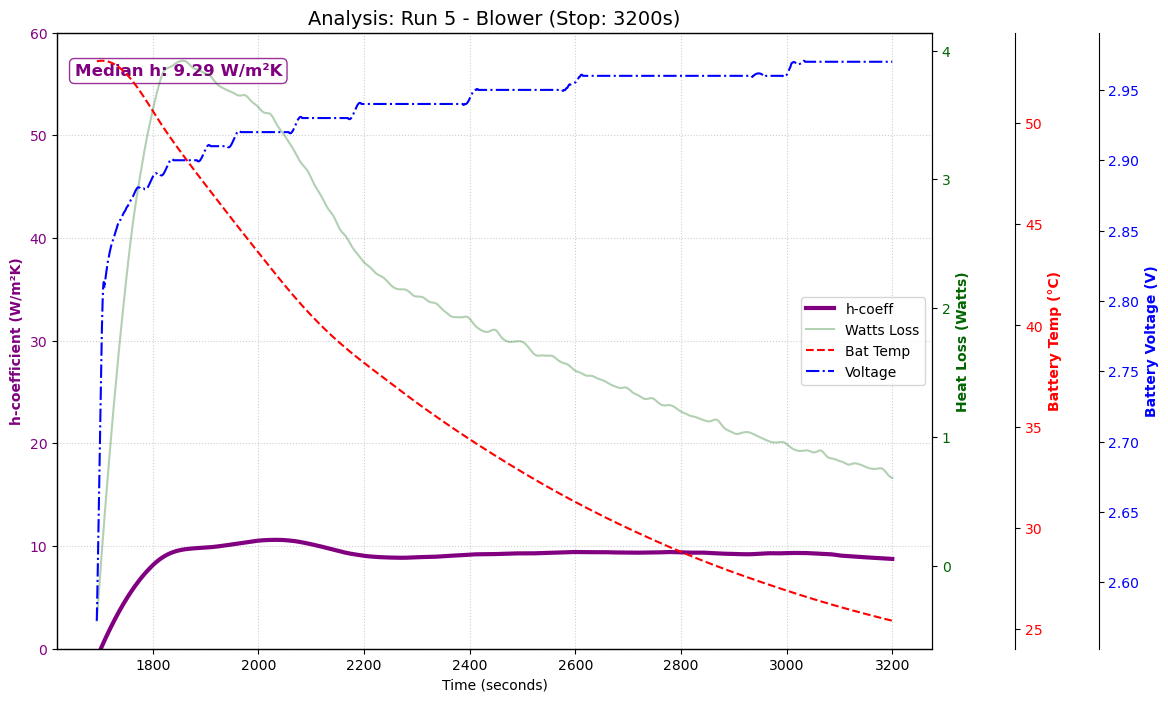

In [94]:
processed_results = [] 

for run in files:
    if not os.path.exists(run['path']):
        print(f"❌ Skipping {run['path']}: File not found.")
        continue

    df = pd.read_csv(run['path'], names=['time_ms', 'v_thermistor', 'temp_battery', 'temp_ambient', 'v_ups', 'v_battery'], skiprows=1)
    for col in ['time_ms', 'temp_battery', 'temp_ambient', 'v_battery']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=['time_ms', 'temp_battery']).copy()
    
    df['time_sec'] = (df['time_ms'] - df['time_ms'].iloc[0]) / 1000
    split_idx = df['temp_battery'].idxmax()

    # Smoothing
    temp_blurred = gaussian_filter1d(df['temp_battery'], sigma=sigma_val)
    df['temp_bat_smooth'] = savgol_filter(temp_blurred, window_size, poly_order)
    df['dT_dt'] = savgol_filter(temp_blurred, window_size, poly_order, deriv=1, delta=1.0)
    df['temp_amb_smooth'] = gaussian_filter1d(df['temp_ambient'] + run['offset'], sigma=sigma_val)
    df['v_bat_smooth'] = savgol_filter(df['v_battery'].ffill(), 51, 2)

    # Physics Stage
    df_settle = df.iloc[split_idx:].copy()
    df_settle = df_settle[df_settle['time_sec'] <= run['stop_time']]
    df_settle = df_settle[(df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']) > 0.1]
    
    df_settle['delta_T'] = df_settle['temp_bat_smooth'] - df_settle['temp_amb_smooth']
    raw_h = -(mc_total * df_settle['dT_dt']) / (total_area * df_settle['delta_T'])
    
    actual_h_win = min(len(df_settle)-1, h_smooth_window)
    if actual_h_win % 2 == 0: actual_h_win -= 1
    df_settle['h_coeff'] = savgol_filter(raw_h, actual_h_win, poly_order) if actual_h_win > 2 else raw_h
    df_settle['watts_loss'] = df_settle['h_coeff'] * total_area * df_settle['delta_T']

    median_h = df_settle['h_coeff'].median()
    
    # --- KEY FIX: Create the 'name' key for Block 3 ---
    processed_results.append({
        'name': f"{run['label']} ({run['desc']})", 
        'power': run['power'], 
        'h': median_h,
        't_max': df['temp_battery'].max(), 
        'time_series': df_settle['time_sec'],
        'h_series': df_settle['h_coeff'], 
        'fit_power_law': run.get('fit_power_law', True)
    })

    # --- FOUR-AXIS INDIVIDUAL PLOT ---
    fig, ax1 = plt.subplots(figsize=(14, 8))
    fig.subplots_adjust(right=0.75) # Adjusted for label room

    # Axis 1: h-coefficient (Purple - Left)
    ax1.set_xlabel('Time (seconds)')
    ax1.set_ylabel('h-coefficient (W/m²K)', color='purple', fontweight='bold')
    p1, = ax1.plot(df_settle['time_sec'], df_settle['h_coeff'], color='purple', linewidth=3, label='h-coeff')
    ax1.set_ylim(0, 60) 
    ax1.tick_params(axis='y', labelcolor='purple')

    # MEDIAN H BOX
    ax1.text(0.02, 0.95, f'Median h: {median_h:.2f} W/m²K', transform=ax1.transAxes, 
             fontsize=12, verticalalignment='top', fontweight='bold', color='purple',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='purple'))

    # Axis 2: Heat Loss (Green - Right 1)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Heat Loss (Watts)', color='darkgreen', fontweight='bold')
    p2, = ax2.plot(df_settle['time_sec'], df_settle['watts_loss'], color='darkgreen', alpha=0.3, label='Watts Loss')
    ax2.tick_params(axis='y', labelcolor='darkgreen')

    # Axis 3: Battery Temp (Red - Right 2, Offset 60)
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Battery Temp (°C)', color='red', fontweight='bold')
    p3, = ax3.plot(df_settle['time_sec'], df_settle['temp_bat_smooth'], color='red', linestyle='--', label='Bat Temp')
    ax3.tick_params(axis='y', labelcolor='red')

    # Axis 4: Battery Voltage (Blue - Right 3, Offset 120)
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('outward', 120))
    ax4.set_ylabel('Battery Voltage (V)', color='blue', fontweight='bold')
    p4, = ax4.plot(df_settle['time_sec'], df_settle['v_bat_smooth'], color='blue', linestyle='-.', label='Voltage')
    ax4.tick_params(axis='y', labelcolor='blue')

    plt.title(f'Analysis: {run["label"]} - {run["desc"]} (Stop: {run["stop_time"]}s)', fontsize=14)
    ax1.grid(True, linestyle=':', alpha=0.6)
    
    # Legend handling
    lines = [p1, p2, p3, p4]
    ax1.legend(lines, [l.get_label() for l in lines], loc='center right')
    
    plt.show()

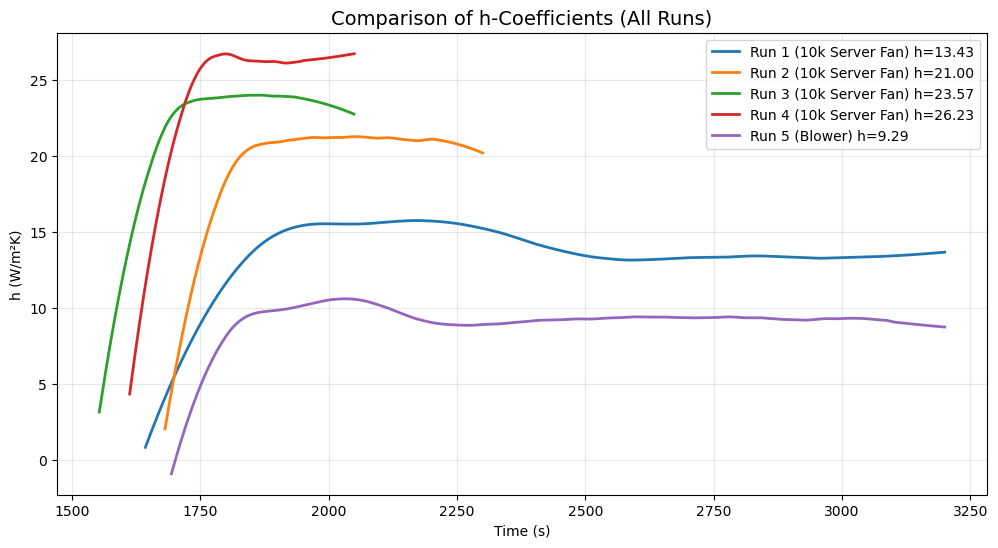

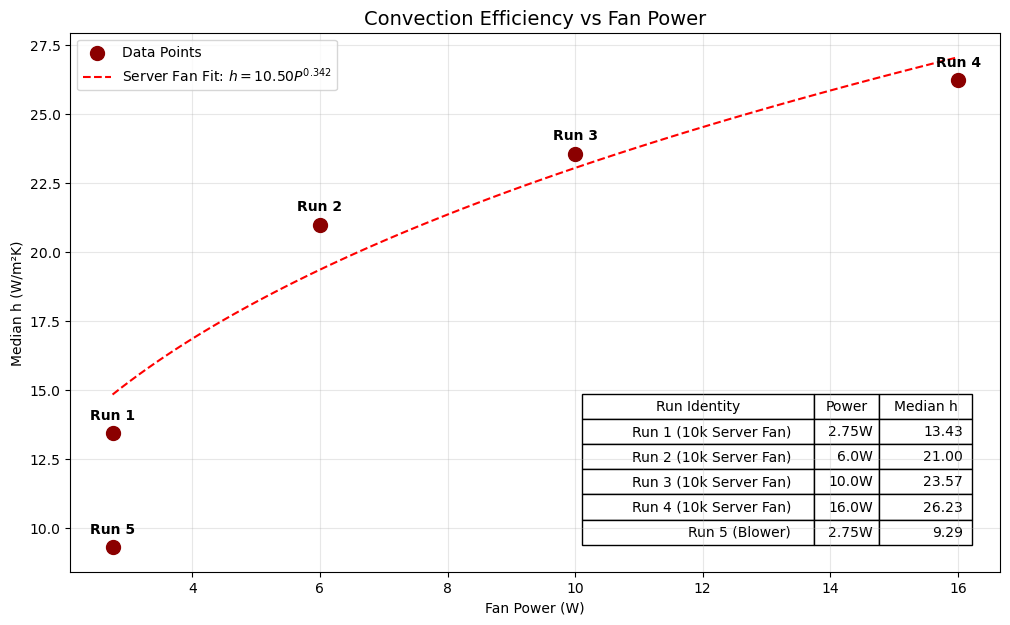

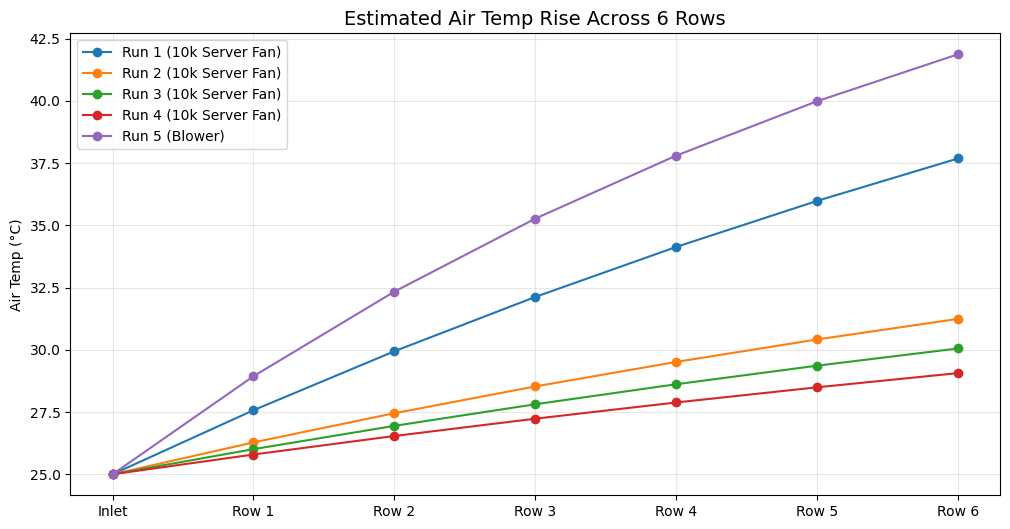

In [96]:
import matplotlib.pyplot as plt

# --- 1. OVERLAY COMPARISON ---
plt.figure(figsize=(12, 6))
for res in processed_results:
    plt.plot(res['time_series'], res['h_series'], label=f"{res['name']} h={res['h']:.2f}", linewidth=2)
plt.title("Comparison of h-Coefficients (All Runs)", fontsize=14)
plt.xlabel("Time (s)"); plt.ylabel("h (W/m²K)"); plt.legend(loc='upper right'); plt.grid(True, alpha=0.3); plt.show()

# --- 2. POWER LAW FIT (Correlation Graph with Auto-Width Table) ---
x_fit = np.array([res['power'] for res in processed_results if res['fit_power_law']])
y_fit = np.array([res['h'] for res in processed_results if res['fit_power_law']])
x_all = np.array([res['power'] for res in processed_results])
y_all = np.array([res['h'] for res in processed_results])

def power_law(P, a, b): return a * np.power(P, b)
popt, _ = curve_fit(power_law, x_fit, y_fit, p0=[5, 0.46])

fig, ax = plt.subplots(figsize=(12, 7))
ax.scatter(x_all, y_all, color='darkred', s=100, label='Data Points', zorder=5)
x_smooth = np.linspace(x_fit.min(), x_fit.max(), 100)
ax.plot(x_smooth, power_law(x_smooth, *popt), 'r--', label=rf'Server Fan Fit: $h = {popt[0]:.2f} P^{{{popt[1]:.3f}}}$')

# Shortened Annotations on dots
for res in processed_results:
    ax.annotate(res['name'].split(' (')[0], (res['power'], res['h']), xytext=(0, 10), 
                textcoords='offset points', ha='center', fontweight='bold')

# --- UPDATED CORRELATION TABLE ---
table_data = [[res['name'], f"{res['power']}W", f"{res['h']:.2f}"] for res in processed_results]
the_table = ax.table(cellText=table_data, 
                     colLabels=['Run Identity', 'Power', 'Median h'], 
                     loc='lower right',
                     bbox=[0.55, 0.05, 0.42, 0.28]) # Widened and heightened the table box

# Auto-adjust column widths based on text length
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.auto_set_column_width(col=list(range(len(table_data[0])))) 

ax.set_title("Convection Efficiency vs Fan Power", fontsize=14)
ax.set_xlabel("Fan Power (W)"); ax.set_ylabel("Median h (W/m²K)"); ax.legend(loc='upper left'); ax.grid(True, alpha=0.3)
plt.show()

# --- 3. AIR TEMP GRADIENT SIMULATION ---
plt.figure(figsize=(12, 6))
for res in processed_results:
    vol_eff = 0.4 if "Blower" in res['name'] else 1.0
    m_dot = 0.0045 * vol_eff * (res['power'] / 10.0)**(0.5) 
    row_temps, curr_t = [t_room], t_room
    for _ in range(n_rows):
        q_actual = min(res['h'] * area_per_row * (res['t_max'] - curr_t), m_dot * cp_air * (res['t_max'] - curr_t))
        curr_t += q_actual / (m_dot * cp_air)
        row_temps.append(curr_t)
    plt.plot(range(n_rows + 1), row_temps, marker='o', label=res['name'])

plt.title("Estimated Air Temp Rise Across 6 Rows", fontsize=14); plt.ylabel("Air Temp (°C)")
plt.xticks(range(n_rows+1), ['Inlet']+[f'Row {i+1}' for i in range(n_rows)]); plt.legend(loc='upper left'); plt.grid(True, alpha=0.3); plt.show()